In [12]:
import sys

In [13]:
import os
from thexp import globs
root = globs['pretrained']

In [20]:
path_to_pretrain_root = os.path.join(root,'rcnn') # dir path of the model file
# print(path_to_pretrain_root) 

In [16]:
sys.argv = sys.argv[:1] + ["--net", "res101", "--dataset", "vg","--load_dir" ,path_to_pretrain_root, '--cuda']

In [18]:
"""visualize results of the pre-trained model """

import argparse
import os
import pdb
import pprint
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from imageio import imread
from torch.autograd import Variable

from model.faster_rcnn.resnet import resnet
from model.roi_layers import nms
from model.rpn.bbox_transform import bbox_transform_inv
from model.rpn.bbox_transform import clip_boxes
from model.utils.blob import im_list_to_blob
from model.utils.config import cfg, cfg_from_file, cfg_from_list
from model.utils.net_utils import vis_detections


def parse_args():
    """
    Parse input arguments
    """
    parser = argparse.ArgumentParser(description='Train a Fast R-CNN network')
    parser.add_argument('--dataset', dest='dataset',
                        help='training dataset',
                        default='vg', type=str)
    parser.add_argument('--cfg', dest='cfg_file',
                        help='optional config file',
                        default='cfgs/res101.yml', type=str)
    parser.add_argument('--net', dest='net',
                        help='vgg16, res50, res101, res152',
                        default='res101', type=str)
    parser.add_argument('--load_dir', dest='load_dir',
                        help='directory to load models',
                        default="models")
    parser.add_argument('--image_dir', dest='image_dir',
                        help='directory to load images for demo',
                        default="images")
    parser.add_argument('--image_file', dest='image_file',
                        help='the file name of load images for demo',
                        default="img1.jpg")
    parser.add_argument('--classes_dir', dest='classes_dir',
                        help='directory to load object classes for classification',
                        default="data/genome/1600-400-20")
    parser.add_argument('--cuda', dest='cuda',
                        help='whether use CUDA',
                        action='store_true')
    parser.add_argument('--mGPUs', dest='mGPUs',
                        help='whether use multiple GPUs',
                        action='store_true')
    parser.add_argument('--set', dest='set_cfgs',
                        help='set config keys', default=None,
                        nargs=argparse.REMAINDER)
    parser.add_argument('--cag', dest='class_agnostic',
                        help='whether perform class_agnostic bbox regression',
                        action='store_true')
    parser.add_argument('--parallel_type', dest='parallel_type',
                        help='which part of model to parallel, 0: all, 1: model before roi pooling',
                        default=0, type=int)
    parser.add_argument('--vis', dest='vis',
                        help='visualization mode',
                        action='store_true')

    args = parser.parse_args()
    return args


lr = cfg.TRAIN.LEARNING_RATE
momentum = cfg.TRAIN.MOMENTUM
weight_decay = cfg.TRAIN.WEIGHT_DECAY

conf_thresh = 0.4
MIN_BOXES = 10
MAX_BOXES = 36


def _get_image_blob(im):
    """Converts an image into a network input.
    Arguments:
      im (ndarray): a color image in BGR order
    Returns:
      blob (ndarray): a data blob holding an image pyramid
      im_scale_factors (list): list of image scales (relative to im) used
        in the image pyramid
    """
    im_orig = im.astype(np.float32, copy=True)
    im_orig -= cfg.PIXEL_MEANS

    im_shape = im_orig.shape
    im_size_min = np.min(im_shape[0:2])
    im_size_max = np.max(im_shape[0:2])

    processed_ims = []
    im_scale_factors = []

    for target_size in cfg.TEST.SCALES:
        im_scale = float(target_size) / float(im_size_min)
        # Prevent the biggest axis from being more than MAX_SIZE
        if np.round(im_scale * im_size_max) > cfg.TEST.MAX_SIZE:
            im_scale = float(cfg.TEST.MAX_SIZE) / float(im_size_max)
        im = cv2.resize(im_orig, None, None, fx=im_scale, fy=im_scale,
                        interpolation=cv2.INTER_LINEAR)
        im_scale_factors.append(im_scale)
        processed_ims.append(im)

    # Create a blob to hold the input images
    blob = im_list_to_blob(processed_ims)

    return blob, np.array(im_scale_factors)


args = parse_args()

# set cfg according to the dataset used to train the pre-trained model
if args.dataset == "pascal_voc":
    args.set_cfgs = ['ANCHOR_SCALES', '[8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]']
elif args.dataset == "pascal_voc_0712":
    args.set_cfgs = ['ANCHOR_SCALES', '[8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]']
elif args.dataset == "coco":
    args.set_cfgs = ['ANCHOR_SCALES', '[4, 8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]']
elif args.dataset == "imagenet":
    args.set_cfgs = ['ANCHOR_SCALES', '[8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]']
elif args.dataset == "vg":
    args.set_cfgs = ['ANCHOR_SCALES', '[4, 8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]']

if args.cfg_file is not None:
    cfg_from_file(args.cfg_file)
if args.set_cfgs is not None:
    cfg_from_list(args.set_cfgs)

cfg.USE_GPU_NMS = args.cuda


print('Using config:')
pprint.pprint(cfg)
np.random.seed(cfg.RNG_SEED)


Using config:
{'ANCHOR_RATIOS': [0.5, 1, 2],
 'ANCHOR_SCALES': [4, 8, 16, 32],
 'CROP_RESIZE_WITH_MAX_POOL': False,
 'CUDA': True,
 'DATA_DIR': '/home/yanghaozhe/binpy/Faster-R-CNN/data',
 'DEDUP_BOXES': 0.0625,
 'EPS': 1e-14,
 'EXP_DIR': 'res101',
 'FEAT_STRIDE': [16],
 'GPU_ID': 0,
 'MATLAB': 'matlab',
 'MAX_NUM_GT_BOXES': 20,
 'MOBILENET': {'DEPTH_MULTIPLIER': 1.0,
               'FIXED_LAYERS': 5,
               'REGU_DEPTH': False,
               'WEIGHT_DECAY': 4e-05},
 'PIXEL_MEANS': array([[[102.9801, 115.9465, 122.7717]]]),
 'POOLING_MODE': 'align',
 'POOLING_SIZE': 7,
 'RESNET': {'FIXED_BLOCKS': 1, 'MAX_POOL': False},
 'RNG_SEED': 3,
 'ROOT_DIR': '/home/yanghaozhe/binpy/Faster-R-CNN',
 'TEST': {'BBOX_REG': True,
          'HAS_RPN': True,
          'MAX_SIZE': 1000,
          'MODE': 'nms',
          'NMS': 0.3,
          'PROPOSAL_METHOD': 'gt',
          'RPN_MIN_SIZE': 16,
          'RPN_NMS_THRESH': 0.7,
          'RPN_POST_NMS_TOP_N': 300,
          'RPN_PRE_NMS_TOP_N': 

/home/yanghaozhe/binpy/Faster-R-CNN/lib/model/utils/config.py:375: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yaml_cfg = edict(yaml.load(f))


In [21]:



# Load faster rcnn model
if not os.path.exists(args.load_dir):
    raise Exception('There is no input directory for loading network from ' + args.load_dir)
load_name = os.path.join(args.load_dir, 'faster_rcnn_{}_{}.pth'.format(args.net, args.dataset))

# Load classes
classes = ['__background__']
with open(os.path.join(args.classes_dir, 'objects_vocab.txt')) as f:
    for object in f.readlines():
        classes.append(object.split(',')[0].lower().strip())

# initilize the network here.
if args.net == 'res101':
    fasterRCNN = resnet(classes, 101, pretrained=False, class_agnostic=args.class_agnostic)
else:
    print("network is not defined")
    pdb.set_trace()

# Build faster rcnn
fasterRCNN.create_architecture()

print("load checkpoint %s" % (load_name))
if args.cuda > 0:
    checkpoint = torch.load(load_name)
else:
    checkpoint = torch.load(load_name, map_location=(lambda storage, loc: storage))
fasterRCNN.load_state_dict(checkpoint['model'])
if 'pooling_mode' in checkpoint.keys():
    cfg.POOLING_MODE = checkpoint['pooling_mode']

    
if args.cuda > 0:
    cfg.CUDA = True

if args.cuda > 0:
    fasterRCNN.cuda()

fasterRCNN.eval()
    
print('load model successfully!')

load checkpoint /home/yanghaozhe/pretrained/rcnn/faster_rcnn_res101_vg.pth
load model successfully!


In [27]:

# initilize the tensor holder here.
im_data = torch.FloatTensor(1)
im_info = torch.FloatTensor(1)
num_boxes = torch.LongTensor(1)
gt_boxes = torch.FloatTensor(1)

# ship to cuda
if args.cuda > 0:
    im_data = im_data.cuda()
    im_info = im_info.cuda()
    num_boxes = num_boxes.cuda()
    gt_boxes = gt_boxes.cuda()

# make variable
with torch.no_grad():
    im_data = Variable(im_data)
    im_info = Variable(im_info)
    num_boxes = Variable(num_boxes)
    gt_boxes = Variable(gt_boxes)



start = time.time()
max_per_image = 100
thresh = 0.05
vis = True

im_file = os.path.join(args.image_dir, args.image_file)
# im = cv2.imread(im_file)
im_in = np.array(imread(im_file))
if len(im_in.shape) == 2:
    im_in = im_in[:, :, np.newaxis]
    im_in = np.concatenate((im_in, im_in, im_in), axis=2)
# rgb -> bgr
im = im_in[:, :, ::-1]

blobs, im_scales = _get_image_blob(im)
assert len(im_scales) == 1, "Only single-image batch implemented"
im_blob = blobs
im_info_np = np.array([[im_blob.shape[1], im_blob.shape[2], im_scales[0]]], dtype=np.float32)

im_data_pt = torch.from_numpy(im_blob)
im_data_pt = im_data_pt.permute(0, 3, 1, 2)
im_info_pt = torch.from_numpy(im_info_np)

with torch.no_grad():
    im_data.resize_(im_data_pt.size()).copy_(im_data_pt)
    im_info.resize_(im_info_pt.size()).copy_(im_info_pt)
    gt_boxes.resize_(1, 1, 5).zero_()
    num_boxes.resize_(1).zero_()
# pdb.set_trace()
det_tic = time.time()

rois, cls_prob, bbox_pred, \
rpn_loss_cls, rpn_loss_box, \
RCNN_loss_cls, RCNN_loss_bbox, \
rois_label,pool_feat = fasterRCNN(im_data, im_info, gt_boxes, num_boxes,pool_feat=True)

scores = cls_prob.data
boxes = rois.data[:, :, 1:5]

if cfg.TEST.BBOX_REG:
    # Apply bounding-box regression deltas
    box_deltas = bbox_pred.data
    if cfg.TRAIN.BBOX_NORMALIZE_TARGETS_PRECOMPUTED:
        # Optionally normalize targets by a precomputed mean and stdev
        if args.class_agnostic:
            if args.cuda > 0:
                box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS).cuda() \
                             + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS).cuda()
            else:
                box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS) \
                             + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS)

            box_deltas = box_deltas.view(1, -1, 4)
        else:
            if args.cuda > 0:
                box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS).cuda() \
                             + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS).cuda()
            else:
                box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS) \
                             + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS)
            box_deltas = box_deltas.view(1, -1, 4 * len(classes))

    pred_boxes = bbox_transform_inv(boxes, box_deltas, 1)
    pred_boxes = clip_boxes(pred_boxes, im_info.data, 1)
else:
    # Simply repeat the boxes, once for each class
    pred_boxes = np.tile(boxes, (1, scores.shape[1]))

pred_boxes /= im_scales[0]

scores = scores.squeeze()
pred_boxes = pred_boxes.squeeze()
det_toc = time.time()
detect_time = det_toc - det_tic
misc_tic = time.time()

max_conf = torch.zeros((pred_boxes.shape[0]))
if args.cuda > 0:
    max_conf = max_conf.cuda()

if vis:
    im2show = np.copy(im)
for j in xrange(1, len(classes)):
    inds = torch.nonzero(scores[:, j] > thresh).view(-1)
    # if there is det
    if inds.numel() > 0:
        cls_scores = scores[:, j][inds]
        _, order = torch.sort(cls_scores, 0, True)
        if args.class_agnostic:
            cls_boxes = pred_boxes[inds, :]
        else:
            cls_boxes = pred_boxes[inds][:, j * 4:(j + 1) * 4]

        cls_dets = torch.cat((cls_boxes, cls_scores.unsqueeze(1)), 1)
        # cls_dets = torch.cat((cls_boxes, cls_scores), 1)
        cls_dets = cls_dets[order]
        # keep = nms(cls_dets, cfg.TEST.NMS, force_cpu=not cfg.USE_GPU_NMS)
        keep = nms(cls_boxes[order, :], cls_scores[order], cfg.TEST.NMS)
        cls_dets = cls_dets[keep.view(-1).long()]
        index = inds[order[keep]]
        max_conf[index] = torch.where(scores[index, j] > max_conf[index], scores[index, j], max_conf[index])
        if vis:
            im2show = vis_detections(im2show, classes[j], cls_dets.cpu().numpy(), 0.5)

if args.cuda > 0:
    keep_boxes = torch.where(max_conf >= conf_thresh, max_conf, torch.tensor(0.0).cuda())
else:
    keep_boxes = torch.where(max_conf >= conf_thresh, max_conf, torch.tensor(0.0))
keep_boxes = torch.squeeze(torch.nonzero(keep_boxes))
if len(keep_boxes) < MIN_BOXES:
    keep_boxes = torch.argsort(max_conf, descending=True)[:MIN_BOXES]
elif len(keep_boxes) > MAX_BOXES:
    keep_boxes = torch.argsort(max_conf, descending=True)[:MAX_BOXES]

In [33]:
pool_feat.shape # feature of each roi 

torch.Size([300, 2048])

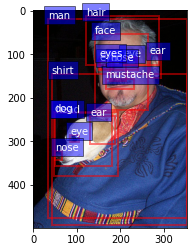

boxes=15


In [23]:
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

boxes = pred_boxes[keep_boxes]
objects = torch.argmax(scores[keep_boxes][:, 1:], dim=1)

for i in range(len(keep_boxes)):
    kind = objects[i] + 1
    bbox = boxes[i, kind * 4: (kind + 1) * 4]
    # bbox = boxes[i]
    if bbox[0] == 0:
        bbox[0] = 1
    if bbox[1] == 0:
        bbox[1] = 1
    cls = classes[objects[i] + 1]
    plt.gca().add_patch(
        plt.Rectangle((bbox[0], bbox[1]),
                      bbox[2] - bbox[0],
                      bbox[3] - bbox[1], fill=False,
                      edgecolor='red', linewidth=2, alpha=0.5)
    )
    plt.gca().text(bbox[0], bbox[1] - 2,
                   '%s' % (cls),
                   bbox=dict(facecolor='blue', alpha=0.5),
                   fontsize=10, color='white')
plt.show()
print('boxes=%d' % (len(keep_boxes)))
